In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense , LSTM, Flatten ,TimeDistributed
from keras.layers.convolutional import Conv1D , MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import math




#Read Input Dataset
data = pd.read_csv('mergedDataset.csv')
data = data[['id', 'player_position', 'player_name', 'last10_ratio_cleanSheets_opp', 'last10_ratio_cleanSheets_own', 'last10_ratio_wins_opp', 'last10_ratio_wins_own', 'last3_assists', 'last3_goals', 'last3_ratio_points', 'last3_ycards', 'opp_team_rank', 'player_team_rank', 'player_value', 'ratio_assists', 'ratio_attempted_passes', 'ratio_big_chancesCreated', 'ratio_big_chancesMiss', 'ratio_creativity', 'ratio_dribbles', 'ratio_fouls', 'ratio_goals_conceded_opp_team', 'ratio_goals_conceded_player_team', 'ratio_goals_opp_team', 'ratio_goals_player_team', 'ratio_goals_scored', 'ratio_key_passes', 'ratio_leading_goal', 'ratio_minutes_played', 'ratio_offsides', 'ratio_open_playcross', 'ratio_own_goals', 'ratio_penalties_conceded', 'ratio_penalties_missed', 'ratio_penalties_saved', 'ratio_saves', 'ratio_selection', 'ratio_tackles', 'ratio_threat', 'week_no', 'season', 'week_points']]


#Split Training & Testing Set
data_refined = data.loc[:,[i for i in list(data.columns) if i not in ['id', 'player_name', 'player_team', 'season']]]
#one-hot encoding for player position
data_refined = pd.get_dummies(data_refined, columns = ['player_position', 'week_no'], drop_first=True)
X_train, X_test, Y_train, Y_test = train_test_split(data_refined.loc[:, data_refined.columns != 'week_points'], data_refined['week_points'], test_size=0.2, random_state=0)





In [14]:
def scale_data_toLSTM(X ,Y):
    # load dataset
    X =  pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    values = X.values

    # integer encode direction
    # encoder = LabelEncoder() #Label encoding (one-hot) for player position at column no.= 9
    # values[:,position_col] = encoder.fit_transform(values[:,position_col])

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(values)
    Y_scaled = scaler.fit_transform(Y.values)
    
    # reshape input to be 3D [samples, timesteps, features] and target data to be [samples,]
    X_scaled = X_scaled.reshape((X_scaled.shape[0],1,X_scaled.shape[1]))
    Y_scaled = Y_scaled.reshape((Y_scaled.shape[0],))
    
    return (X_scaled , Y_scaled, scaler)




In [15]:
test_X , test_y,scaler = scale_data_toLSTM(X_test, Y_test )
train_X , train_y,scaler = scale_data_toLSTM(X_train, Y_train)

/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 34657 samples, validate on 8665 samples
Epoch 1/15
34657/34657 [==============================] - 10s 299us/step - loss: 0.0073 - val_loss: 0.0078
Epoch 2/15
34657/34657 [==============================] - 9s 250us/step - loss: 0.0066 - val_loss: 0.0072
Epoch 3/15
34657/34657 [==============================] - 7s 188us/step - loss: 0.0065 - val_loss: 0.0070
Epoch 4/15
34657/34657 [==============================] - 7s 214us/step - loss: 0.0064 - val_loss: 0.0069
Epoch 5/15
34657/34657 [==============================] - 7s 192us/step - loss: 0.0064 - val_loss: 0.0069
Epoch 6/15
34657/34657 [==============================] - 7s 205us/step - loss: 0.0064 - val_loss: 0.0068
Epoch 7/15
34657/34657 [==============================] - 8s 226us/step - loss: 0.0064 - val_loss: 0.0068
Epoch 8/15
34657/34657 [==============================] - 7s 208us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 9/15
34657/34657 [==============================] - 7s 202us/step - loss: 0.0063 - val_loss: 0.0

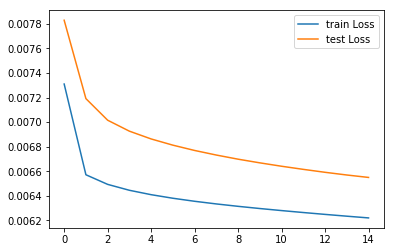

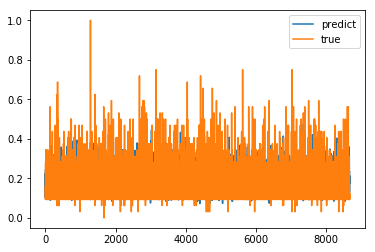

In [16]:

multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mse', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=15, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)


pyplot.plot(multi_history.history['loss'], label='train Loss')
pyplot.plot(multi_history.history['val_loss'], label='test Loss')
pyplot.legend()
pyplot.show()




yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()





In [17]:
test_X , test_y,scaler = scale_data_toLSTM(X_test, Y_test )
train_X , train_y,scaler = scale_data_toLSTM(X_train, Y_train)

test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
mse = mean_squared_error(inv_y, inv_yhat)
mse

/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


4.774520664241943

4.732633473893638